In [166]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import solve
from scipy.linalg import norm
from scipy.integrate import solve_ivp
from function_list import *
plt.rcParams['text.usetex'] = True
from scipy.stats import chisquare

### Tutorial 2: Question 3
We seek to solve the following boundary value problem 
\begin{equation}
y'' = -\frac{2}{x}y' + \frac{2}{x^2}y+\frac{\sin(\ln x)}{x^2},\quad y(1)=1,\quad y(2)=2
\end{equation}
using the shooting method and the finite difference method.

#### Shooting Method
The boundary value problem can be expressed as two first order differential equations
\begin{equation}
\begin{cases}
y'=u \\
u'=-\frac{2}{x}u+\frac{2}{x^2}y+\frac{\sin(\ln x)}{x^2}
\end{cases}
\end{equation}
with initial conditions $y(1)=1$ and $y'(1)=p$.

In [167]:
def f(x, y):
    return y[1], -(2/x)*y[1]+(2/(x**2))*y[0]+(np.sin(np.log(x)))/(x**2)

We can determine an approximate interval $c\leq p\leq d$ such that
\begin{equation}
\begin{cases}
y(2)-2 < 0,&\quad p=c \\
y(2)-2 > 0,&\quad p=d
\end{cases}
\end{equation}

In [168]:
x = np.linspace(1, 2, 100)
for i in np.linspace(0, 2, 10):
    yprime = i
    y0 = [1, yprime]
    
    sol = solve_ivp(f, [1, 2], y0, t_eval=x)
    y = sol.y[0, :]

    if y[-1] - 2 < 0:
        print('p={:.5f}, greater than'.format(i))
    elif y[-1] - 2 > 0:
        print('p={:.5f}, less than'.format(i))
    

p=0.00000, greater than
p=0.22222, greater than
p=0.44444, greater than
p=0.66667, greater than
p=0.88889, greater than
p=1.11111, less than
p=1.33333, less than
p=1.55556, less than
p=1.77778, less than
p=2.00000, less than


We observe that $p$ lies in the approximate interval $0.89\leq p\leq 1.11$. We can now implement the bisection method to find $p$ such that 
\begin{equation}
|y_{n-1}-y_n|<\varepsilon
\end{equation}
where $\varepsilon$ is a set tolerance.

In [169]:
def shooting_method_f(p, x, tol=10**(-6)):
    pstart, pend = p
    n_iterations = 0

    while np.abs(pend - pstart) > tol:
        updated_p = (pend + pstart) / 2
        y0 = [1, updated_p]
        sol = solve_ivp(f, [1, 2], y0, t_eval=x)
        y = sol.y[0, :]

        if y[-1] - 2 < 0:
            pstart = updated_p
        elif y[-1] - 2 > 0:
            pend = updated_p

        diff = np.abs(pend - pstart)
        n_iterations += 1

    return [y, n_iterations]

We can now plot the solution obtained by the shooting method along with the exact solution 
\begin{equation}
y(x)=c_1 x + \frac{c_2}{x^2}-\frac{3}{10}\sin(\ln x) - \frac{1}{10}\cos(\ln x)
\end{equation}
where 
\begin{equation}
c_2 = \frac{1}{70}\left[8-12\sin(\ln 2) - 4\cos(\ln 2)\right],\quad c_1 = \frac{11}{10}-c_2
\end{equation}

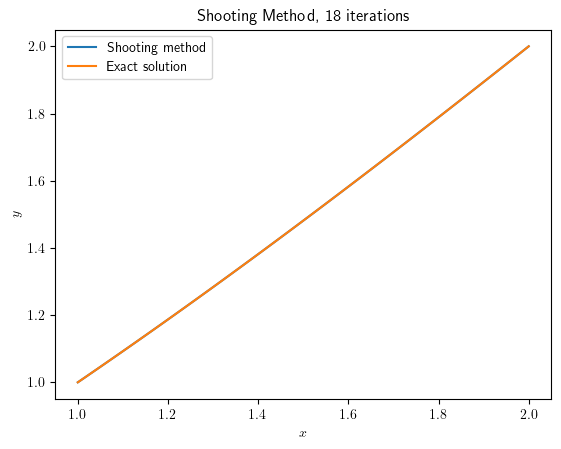

In [170]:
def exact_f(x):
    
    def c_2():
        return (1/70)*(8-12*np.sin(np.log(2))-4*np.cos(np.log(2)))
    
    def c_1(c_2):
        return (11/10) - c_2
    
    return c_1(c_2())*x + c_2()/(x**2) - (3/10)*np.sin(np.log(x)) - (1/10)*np.cos(np.log(x))

y, n_iterations = shooting_method_f([0.89, 1.11], x)

plt.plot(x, y, label='Shooting method')
plt.plot(x, exact_f(x), label='Exact solution')
plt.title(r'Shooting Method, {} iterations'.format(n_iterations))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

#### Finite Difference Method
Expressing the boundary value problem as
\begin{equation}
F(y)=
\begin{cases}
y''+\frac{2}{x}y'-\frac{2}{x^2}y-\frac{\sin(\ln x)}{x^2}=0 \\
y(1) - 1 = 0 \\
y(2) - 2 = 0
\end{cases}
\end{equation}


The Fréchet derivative is
\begin{equation}
F'(z)=
\begin{cases}
z''+\frac{2}{x}z'-\frac{2}{x^2}z \\
z(1) \\ 
z(2)
\end{cases}
\end{equation}

Then the Newton-Kantorovich equation $F'z=-F$ is
\begin{align}
z''+\frac{2}{x}z'-\frac{2}{x^2}z &= -\left[y''+\frac{2}{x}y'-\frac{2}{x^2}y-\frac{\sin(\ln x)}{x^2}\right] \\
z(1) &= -\left[ y(1) - 1 \right] \\
z(2) &= -\left[ y(2) - 2 \right]
\end{align}

We now want to solve this system using finite differences. Let $h$ be the space step such that
\begin{equation}
h=\frac{b-a}{N}
\end{equation}
so there are $N+1$ points and $N$ spacings between those points of width $h$.

In [171]:
a, b = [1, 2] # [start point, end point]
N = 1000 # number of points
h = (b-a)/N # space width
x = np.linspace(a, b, N+1) # space interval
tol = 10**(-6) # tolerance

Substituting the centred finite differences into the Newton-Kantorovich equation 
\begin{align}
\frac{z_{j-1} - 2z_j + z_{j+1}}{h^2} + \frac{2}{x_j}\frac{z_{j+1}-z_{j-1}}{2h} - \frac{2}{x_j^2}z_j &= -\left[ \frac{y_{j-1} - 2y_j + y_{j+1}}{h^2} + \frac{2}{x_j}\frac{y_{j+1}-y_{j-1}}{2h} - \frac{2}{x_j^2}y_j - \frac{\sin(\ln x_j )}{x_j^2} \right] \\
z_1 &= -\left[ y_1 - 1\right] \\
z_{N+1} &= -\left[y_{N+1} - 2 \right]
\end{align}

Factoring the left hand side in terms of $z$
\begin{align}
z_{j-1}\left[\frac{1}{h^2} - \frac{1}{x_j}\frac{1}{h}\right] + z_j\left[-\frac{2}{h^2}-\frac{2}{x_j^2}\right] + z_{j+1}\left[\frac{1}{h^2}+\frac{1}{x_j}\frac{1}{h}\right] &= -\left[ \frac{y_{j-1} - 2y_j + y_{j+1}}{h^2} + \frac{2}{x_j}\frac{y_{j+1}-y_{j-1}}{2h} - \frac{2}{x_j^2}y_j - \frac{\sin(\ln x_j )}{x_j^2} \right] \\
z_1 &= -\left[ y_1 - 1\right] \\
z_{N+1} &= -\left[y_{N+1} - 2 \right]
\end{align}

We can now express $F^{\,\prime}$ as a Jacobian matrix

In [172]:
def jacobian_f(N, x, y, h):
    jacobian = np.zeros((N+1, N+1))
    
    jacobian[(0,0)] = 1
    jacobian[(N,N)] = 1
    
    diag_1, diag_2, diag_3 = [], [], []
    
    for i in range(1,N):
        diag_1.append(1/(h**2) - (1/x[i])*(1/h))
        diag_2.append(-(2/(h**2))-(2/x[i]**2))
        diag_3.append(1/(h**2) + (1/x[i])*(1/h))
        
    np.fill_diagonal(jacobian[1:, :N - 1], diag_1)
    np.fill_diagonal(jacobian[1:N, 1:N], diag_2)
    np.fill_diagonal(jacobian[1:N + 1, 2:N + 1], diag_3)

    return jacobian

Similarly, we can express $-F$ as a vector to solve $F'z=-F$

In [173]:
def finite_diff_first(y2, y1, h):
    return (y2-y1)/(2*h)

def finite_diff_second(y3, y2, y1, h):
    return (y1 -2*y2 + y3)/(h**2)


def vec_f(N, x, y, h):
    A = np.zeros(N + 1)
    
    A[0] = -y[0] + 1
    A[N] = -y[N] + 2

    for i in range(1, N):
        A[i] = (-finite_diff_second(y[i+1], y[i], y[i-1], h) - (2/x[i])*finite_diff_first(y[i+1], y[i-1], h)
                +(2/x[i]**2)*y[i] - (np.sin(np.log(x[i]))/x[i]**2))

    return A

We can now create a while loop to iteratively solve for $\vec{y}$ with corrections $\vec{z}$

In [174]:
def newton_kantorovich_method_f(N, x, y, h, tol=10**(-6)):
    n_iterations = 0
    A = vec_f(N, x, y, h)

    while norm(A) > tol and n_iterations < 100:
        jacobian = jacobian_f(N, x, y, h)
        z = solve(jacobian, A)
        y = y + z
        A = vec_f(N, x, y, h)
        n_iterations = n_iterations + 1

    return [y, n_iterations]

We can now test this using the values obtained from the shooting method as the ansatz for $y$ 

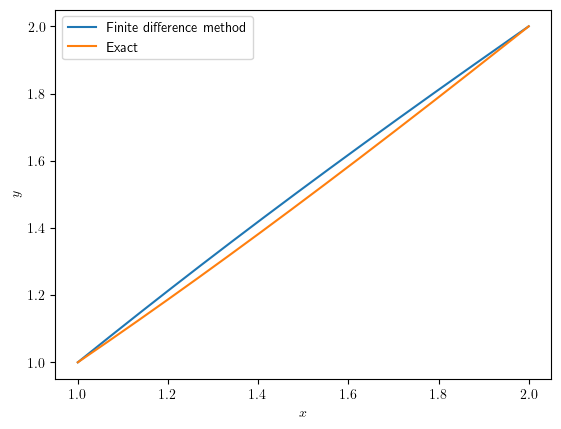

In [175]:
y_ansatz = shooting_method_f([0.89, 1.11], x)[0]
y, n_iterations = newton_kantorovich_method_f(N, x, y_ansatz, h)
plt.plot(x, y, label=r'Finite difference method')
plt.plot(x, exact_f(x), label=r'Exact')
plt.legend(loc='best')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.show()